In [3]:
import torch
import transformers
# from transformers import RobertaTokenizer, RobertaModel
from transformers import *
# from transformers.models.roberta.modeling_roberta import RobertaModel

# from transformers
# tokenizer = AutoTokenizer.from_pretrained("TODBERT/TOD-BERT-JNT-V1")
# tod_bert = AutoModel.from_pretrained("TODBERT/TOD-BERT-JNT-V1")

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-large-mnli")
bert = RobertaModel.from_pretrained("roberta-large-mnli")

In [4]:
print(transformers.__version__)

3.3.0


In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [6]:
# datapath = f'bbc-text.csv'
#Path
df = pd.read_csv('csv/train.csv')
val= pd.read_csv('csv/valid.csv')
test = pd.read_csv('csv/test.csv')

<AxesSubplot:xlabel='emotion'>

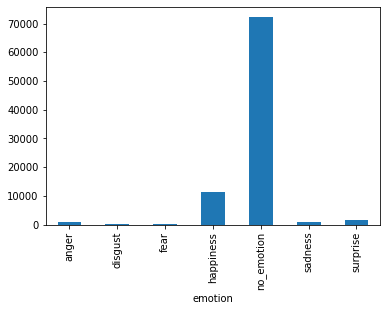

In [7]:
df.groupby(['emotion']).size().plot.bar()

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['topic'])
c = list(le.classes_)
labels={}
for idx, la in enumerate(c):
    labels.update({la:idx})

In [9]:
c = list(le.classes_)
labels={}
for idx, la in enumerate(c):
    labels.update({la:idx})
labels

{'attitude_and_emotion': 0,
 'culture_and_educastion': 1,
 'finance': 2,
 'health': 3,
 'ordinary_life': 4,
 'politics': 5,
 'relationship': 6,
 'school_life': 7,
 'tourism': 8,
 'work': 9}

In [10]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# labels = {'afraid':0,
#           'angry':1,
#           'anxious':2,
#           'disgusted':3,
#           'embarrassed':4,
#           'excited':5,
#           'guilty':6,
#           'jealous':7,
#           'joyful':8,
#           'lonely':9,
#           'proud':10,
#           'sad':11,
#           'sentimental':12,
#           'terrified':13,
#           'trusting':14,
#           }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [torch.tensor(labels[label], dtype=torch.long) for label in df['topic']]
        self.texts  = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]
        # self.story = torch.Tensor(tokenizer.convert_tokens_to_ids(self.texts)).long()

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [11]:
class Classifier(nn.Module):

    def __init__(self, dropout=0.2):

        super(Classifier, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1024, 7)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [12]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    #GPU
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [41]:
def evaluate(model, test_data):
    
    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    all_testlabel=[]
    all_output=[]
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            
            #   print(test_label)
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
              
              all_testlabel.append(test_label.cpu())
              all_output.append(output.cpu().argmax(dim=1))
              
    import itertools
    from sklearn.metrics import f1_score, confusion_matrix
    testlabels=list(itertools.chain.from_iterable(all_testlabel))
    print(testlabels)
    outputs = list(itertools.chain.from_iterable(all_output))
    f1_score = f1_score(testlabels, outputs,average='micro')
    confusion_matrix = confusion_matrix(testlabels, outputs)
    
              
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print(f'f1 score:',f1_score)
    print(f'confusion_matrix:\n',confusion_matrix)

In [34]:
import itertools
a = [['a','b'], ['c']]
print(list(itertools.chain.from_iterable(a)))

['a', 'b', 'c']


In [14]:
np.random.seed(2019)
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
#                                      [int(.8*len(df)), int(.9*len(df))])

print(len(df),len(val), len(test))

87170 8069 7740


In [15]:
# EPOCHS = 5
# model = Classifier()
# LR = 1e-6
              
# train(model, df, val, LR, EPOCHS)

In [16]:
# evaluate(model, test)

In [17]:
class Topic_Classifier(nn.Module):
    
    def __init__(self, dropout=0.1):

        super(Topic_Classifier, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1024, 128)
        self.linear2 = nn.Linear(512, 128)
        self.linear3 = nn.Linear(128, 10)
        # self.linear2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        linear_output2 = self.linear2(linear_output)
        linear_output3 = self.linear3(linear_output2)
        final_layer = self.relu(linear_output3)

        return final_layer

In [18]:
class Act_Classifier(nn.Module):
    
    def __init__(self, dropout=0.1):

        super(Act_Classifier, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(1024, 256)
        self.linear2 = nn.Linear(256, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        linear_output2 = self.linear2(linear_output)
        final_layer = self.relu(linear_output2)

        return final_layer

### Evaluation Mode

In [19]:
import torch
model = Topic_Classifier()

# model.load_state_dict(torch.load('models/model_roberta_1.pt'))

model = torch.load('models/model_topic_48.pt')
model.eval()

Topic_Classifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): L

In [40]:
# test = pd.read_csv('csv/test.csv')

In [38]:
evaluate(model, test)

[tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(9, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='cuda:0'), tensor(4, device='c

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# Encode text 
input_text = "[CLS] [SYS] Hello, what can I help with you today? [USR] Find me a cheap restaurant nearby the north town."
input_tokens = tokenizer.tokenize(input_text)
story = torch.Tensor(tokenizer.convert_tokens_to_ids(input_tokens)).long()

if len(story.size()) == 1: 
    story = story.unsqueeze(0) # batch size dimension

if torch.cuda.is_available(): 
    bert = bert.cuda()
    story = story.cuda()

with torch.no_grad():
    input_context = {"input_ids": story, "attention_mask": (story > 0).long()}
    hiddens = tod_bert(**input_context)[0] 